In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer
from sklearn.preprocessing import MaxAbsScaler

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

from imblearn.over_sampling import *
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import seaborn as sns

In [110]:
# Load the CSV file into a DataFrame
file_path = 'retailer.csv'  # Update with your file's correct path
df_retailer = pd.read_csv(file_path)

# Display the first few rows of the DataFrame to verify
display(df_retailer.head(10))

,customer_id,timestamp_utc,event_name,brand,product_name,sales,quantity
0,reFs5GI87lXJkJSi9r,2024-02-07 02:27:10,Product Page View,NaN,NaN,NaN,NaN
1,reFs5GI87lXJkJSi9r,2024-06-12 16:16:54,Product Page View,Science Diet,SD Fel A7+ SavCknEnt 24x5.5oz cs,NaN,NaN
2,reTjziox2cSrxVq70Y,2024-02-28 04:11:46,Product Page View,NaN,NaN,NaN,NaN
3,reTjziox2cSrxVq70Y,2024-02-28 04:30:42,Product Page View,Science Diet,SD Fel Adt HBC OFEnt 24x5.5oz cs,NaN,NaN
4,reOrpt9vhSwhbPVtni,2024-06-01 22:22:30,Product Page View,NaN,NaN,NaN,NaN
5,reOrpt9vhSwhbPVtni,2024-06-01 22:36:26,Product Page View,Science Diet,SD Ca Adt Lt Ckn 30lb bg,NaN,NaN
6,reOrpt9vhSwhbPVtni,2024-06-01 22:43:07,Product Page View,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,NaN,NaN
7,reOrpt9vhSwhbPVtni,2024-06-20 14:02:48,Product Page View,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,NaN,NaN
8,reOrpt9vhSwhbPVtni,2024-06-06 10:38:51,Order,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,19.99,1.0
9,reOrpt9vhSwhbPVtni,2024-06-01 22:47:09,Add to cart,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,NaN,NaN


In [111]:
print(len(df_retailer))

9866049


# Missing Values

In [112]:
print(df_retailer.dtypes)

customer_id       object
timestamp_utc     object
event_name        object
brand             object
product_name      object
sales            float64
quantity         float64
dtype: object


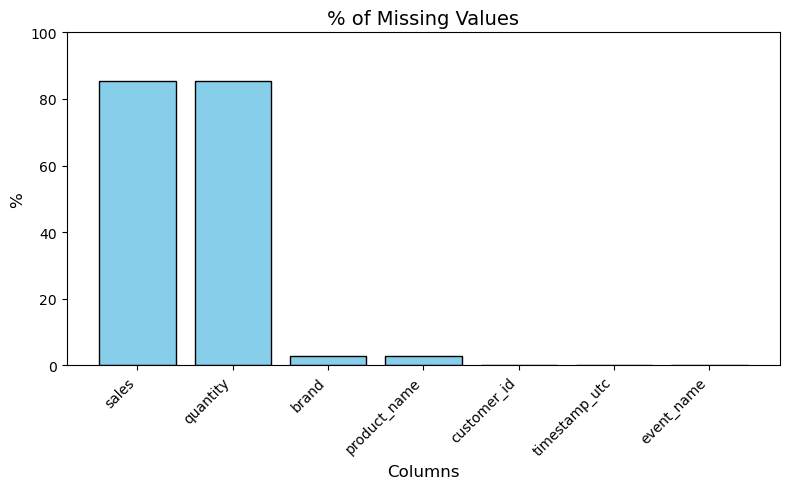

               Missing Count  Missing Percentage (%)
sales                8426738               85.411475
quantity             8426738               85.411475
brand                 277240                2.810041
product_name          277240                2.810041
customer_id                0                0.000000
timestamp_utc              0                0.000000
event_name                 0                0.000000


In [113]:
def count_missing_values_summary(df):
    missing_counts = df.isnull().sum()
    missing_percentage = (missing_counts / len(df)) * 100
    missing_columns = missing_counts[missing_counts > 0]
    missing_summary = pd.DataFrame({
        'Missing Count': missing_counts,
        'Missing Percentage (%)': missing_percentage}
    ).sort_values(by='Missing Count', ascending=False)
    
    # Create the histogram
    plt.figure(figsize=(8, 5))
    plt.ylim(0, 100)
    plt.bar(missing_summary.index, missing_summary['Missing Percentage (%)'], color='skyblue', edgecolor='black')
    plt.xlabel('Columns', fontsize=12)
    plt.ylabel('%', fontsize=12)
    plt.title('% of Missing Values', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    return missing_summary

# Example usage
summary = count_missing_values_summary(df_retailer)
print(summary)

## Data Types - Numeric

In [114]:
print("\nDescriptive statistics for 'sales':")
print(df_retailer['sales'].describe())

print("\nDescriptive statistics for 'quantity':")
print(df_retailer['quantity'].describe())


Descriptive statistics for 'sales':
count    1.439311e+06
mean     4.337350e+01
std      2.761782e+01
min      0.000000e+00
25%      2.248000e+01
50%      4.187000e+01
75%      5.599000e+01
max      1.184700e+03
Name: sales, dtype: float64

Descriptive statistics for 'quantity':
count    1.439311e+06
mean     1.081074e+00
std      4.033814e-01
min      0.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      3.000000e+01
Name: quantity, dtype: float64


#### 'sales' and 'quantity' in correlation to 'event_name', to figure out where the missing values are listed

In [115]:
# List all unique attributes in the 'event_name' column
unique_event_names = df_retailer['event_name'].unique()

# Print the unique event names
print("Unique event_name attributes:")
print(unique_event_names)

# Group by 'event_name' and count missing values in 'sales'
nan_sales_by_event = df_retailer[df_retailer['sales'].isnull()].groupby('event_name').size()

print("Missing sales counts by event_name:")
print(nan_sales_by_event)

Unique event_name attributes:
['Product Page View' 'Order' 'Add to cart']
Missing sales counts by event_name:
event_name
Add to cart          2050111
Product Page View    6376627
dtype: int64


Proportion of missing sales by event_name (in %):
event_name
Add to cart          100.0
Order                  NaN
Product Page View    100.0
dtype: float64
                       sales  quantity  event_count
event_name                                         
Add to cart              NaN       NaN      2050111
Order              43.373495  1.081074      1439311
Product Page View        NaN       NaN      6376627


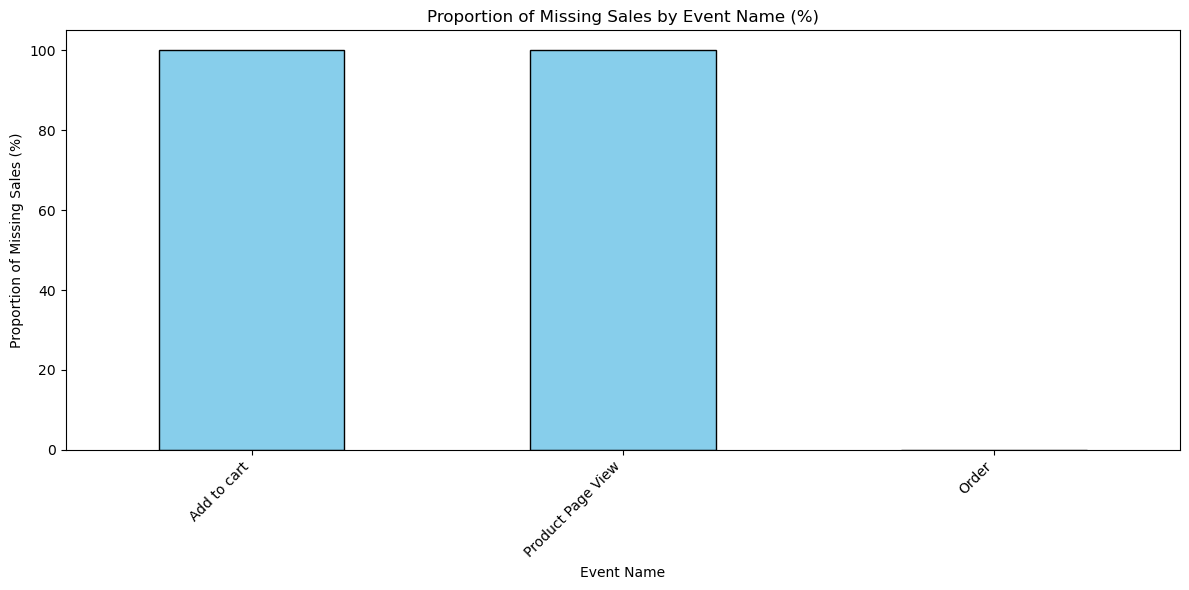

In [116]:
# Calculate the total rows per 'event_name'
total_by_event = df_retailer.groupby('event_name').size()

# Proportion of missing 'sales' per 'event_name' (in percentage)
missing_sales_proportion = (nan_sales_by_event / total_by_event) * 100
print("Proportion of missing sales by event_name (in %):")
print(missing_sales_proportion)

event_summary = df_retailer.groupby('event_name').agg({
    'sales': 'mean',
    'quantity': 'mean',
    'event_name': 'count'
}).rename(columns={'event_name': 'event_count'})

print(event_summary)

# Sort values for better visualization
missing_sales_proportion = missing_sales_proportion.sort_values(ascending=False)

# Plot the proportions
missing_sales_proportion.plot(kind='bar', figsize=(12, 6), color='skyblue', edgecolor='black')
plt.title('Proportion of Missing Sales by Event Name (%)')
plt.ylabel('Proportion of Missing Sales (%)')
plt.xlabel('Event Name')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

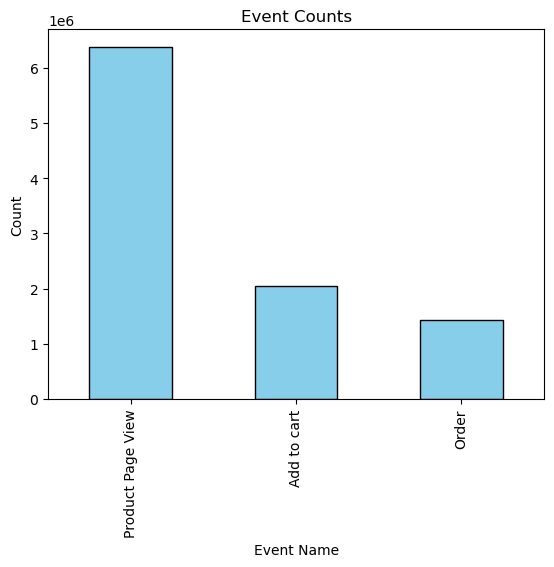

In [117]:
event_counts = df_retailer['event_name'].value_counts()
event_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Event Counts')
plt.xlabel('Event Name')
plt.ylabel('Count')
plt.show()

### Decision: Replace missing (NaN) values in the sales and quantity columns with 0

In [118]:
# Impute missing values for non-transactional events
df_retailer.loc[df_retailer['event_name'] != 'Order', ['sales', 'quantity']] = df_retailer.loc[
    df_retailer['event_name'] != 'Order', ['sales', 'quantity']
].fillna(0)

In [119]:
event_summary = df_retailer.groupby('event_name').agg({
    'sales': 'mean',
    'quantity': 'mean',
    'event_name': 'count'
}).rename(columns={'event_name': 'event_count'})

print(event_summary)

                       sales  quantity  event_count
event_name                                         
Add to cart         0.000000  0.000000      2050111
Order              43.373495  1.081074      1439311
Product Page View   0.000000  0.000000      6376627


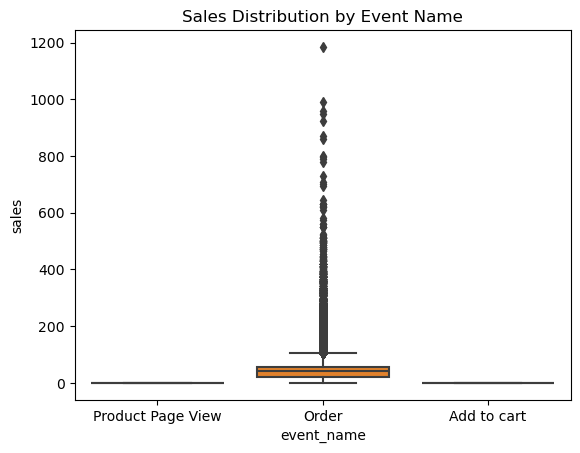

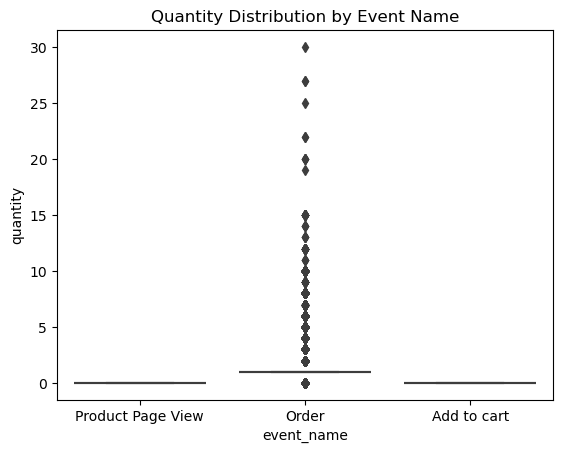

In [120]:
sns.boxplot(x='event_name', y='sales', data=df_retailer)
plt.title('Sales Distribution by Event Name')
plt.show()

sns.boxplot(x='event_name', y='quantity', data=df_retailer)
plt.title('Quantity Distribution by Event Name')
plt.show()

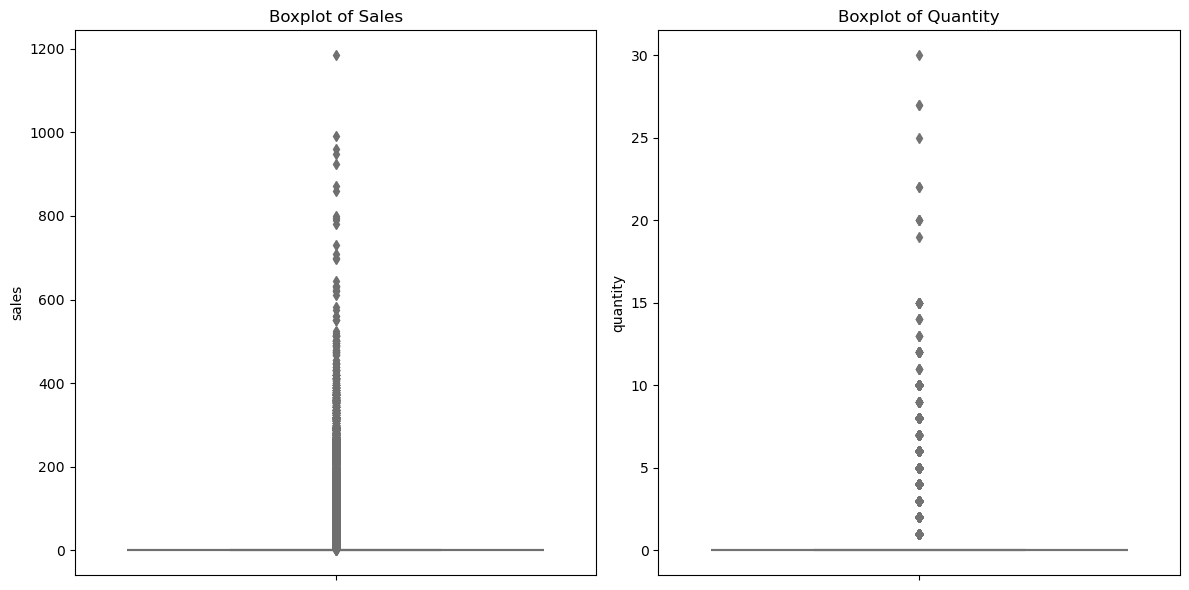

In [121]:
# Plot boxplots for 'sales' and 'quantity'
plt.figure(figsize=(12, 6))

# Boxplot for sales
plt.subplot(1, 2, 1)
sns.boxplot(y=df_retailer['sales'], color='skyblue')
plt.title('Boxplot of Sales')

# Boxplot for quantity
plt.subplot(1, 2, 2)
sns.boxplot(y=df_retailer['quantity'], color='lightgreen')
plt.title('Boxplot of Quantity')

plt.tight_layout()
plt.show()

In [122]:
# Function to identify outliers
def detect_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect outliers in 'sales' and 'quantity'
sales_outliers, sales_lower, sales_upper = detect_outliers(df_retailer, 'sales')
quantity_outliers, quantity_lower, quantity_upper = detect_outliers(df_retailer, 'quantity')

# Calculate percentages of outliers
sales_outliers_percentage = len(sales_outliers) / len(df_retailer) * 100
quantity_outliers_percentage = len(quantity_outliers) / len(df_retailer) * 100

print(f"Percentage of sales outliers: {sales_outliers_percentage:.2f}%")
print(f"Percentage of quantity outliers: {quantity_outliers_percentage:.2f}%")


Percentage of sales outliers: 14.52%
Percentage of quantity outliers: 14.56%


In [123]:
# Detect top outliers for 'sales'
top_sales_outliers = sales_outliers.sort_values(by='sales', ascending=False)

# Detect top outliers for 'quantity'
top_quantity_outliers = quantity_outliers.sort_values(by='quantity', ascending=False)

# Display the top 10 outliers for sales and quantity
print("Top 10 outliers for Sales:")
display(top_sales_outliers.head(10))

print("\nTop 10 outliers for Quantity:")
display(top_quantity_outliers.head(10))

Top 10 outliers for Sales:


,customer_id,timestamp_utc,event_name,brand,product_name,sales,quantity
5074896,reCCL85BR3ZuPZaIdd,2024-05-13 20:50:25,Order,Science Diet,SD Ca Adt Ckn 35lb Sh,1184.70,15.0
4386311,reTSaSzm8aOpKuxHgT,2024-02-01 17:32:43,Order,Prescription Diet,PD z/d Ultra AllergnFreeCanine 25lb bg,991.92,8.0
6526245,restOfOpKAOVEQ83fL,2024-01-24 19:21:08,Order,Science Diet,SD Ca Adt LM&BR 33lb bg,959.88,12.0
6158736,reFPcJWFkM9ciE15V2,2024-05-15 16:58:06,Order,Science Diet,SD Ca Adt Ckn 35lb Sh,947.76,12.0
3301872,renyhzUbN0lc2Rmyp5,2024-06-09 05:11:33,Order,Prescription Diet,PD Canine u/d 27.5lb bg,923.93,7.0
1392155,re5Ob80et78xa9tVp1,2024-06-21 17:19:50,Order,Science Diet,SD Fel Adt 12x5.5oz VarPk,872.10,30.0
46894,reEUpgwfumUHVRcuHk,2024-01-03 02:02:31,Order,Science Diet,SD Ca Adt PerWgt Ckn 25lb bg,859.90,10.0
7670581,reD4mC3IU6zXsH1MCB,2024-01-12 04:40:14,Order,Science Diet,SD Ca Adt SenSt&Sk Ckn 30lb bg,799.80,10.0
5769264,reuRH3FXYwvW6Y7d0X,2024-04-08 23:00:09,Order,Science Diet,SD Ca Adt SavStw w/Bf&Vg 12x12.8oz cs,795.53,19.0
6575535,rez17boFY70iDDhNYm,2024-04-28 00:38:35,Order,Science Diet,SD Ca Adt Lt LB Ckn 30lb bg,789.90,10.0



Top 10 outliers for Quantity:


,customer_id,timestamp_utc,event_name,brand,product_name,sales,quantity
1392155,re5Ob80et78xa9tVp1,2024-06-21 17:19:50,Order,Science Diet,SD Fel Adt 12x5.5oz VarPk,872.10,30.0
1083687,redhghMAoLgT03txrO,2024-04-07 03:27:38,Order,Hills,HI Ca NatJkySt Bf 12x7.1oz cs,210.33,27.0
2620645,re6zja5QSjxjIuIW8v,2024-04-23 21:13:43,Order,Hills,HI Ca Nat BkdLtBisc Sm w/Ckn 12x8oz cs,210.87,27.0
2518922,rewWhW8fJnm3Rv0Agr,2024-04-23 15:16:34,Order,Hills,HI Ca Nat TrT Ckn 12x3oz cs,124.75,25.0
2467729,regOtc0cFHeGpzvuPP,2024-05-22 22:25:43,Order,Hills,HI Ca GF SBkNat Ckn&Car 12x8oz cs,171.38,22.0
2838205,revqm0mCZJSN9Xkx6S,2024-06-18 14:50:12,Order,Hills,HI Ca Nat TrT Ckn 12x3oz cs,109.78,22.0
2833504,reNYEAObjSbKwEpoNe,2024-01-06 04:47:19,Order,Hills,HI Ca Nat TrT Ckn 12x3oz cs,95.80,20.0
2620644,re6zja5QSjxjIuIW8v,2024-03-12 17:40:28,Order,Hills,HI Ca Nat BkdLtBisc Sm w/Ckn 12x8oz cs,156.20,20.0
2620646,re6zja5QSjxjIuIW8v,2024-05-16 18:46:11,Order,Hills,HI Ca Nat BkdLtBisc Sm w/Ckn 12x8oz cs,156.20,20.0
7274704,re839jKteXN4Ctijeg,2024-02-01 15:53:33,Order,Science Diet,SD Pup SB Ckn 4.5lb bg,379.80,20.0


#### Decision: Keep Outliers, since they are valid and represent extreme but meaningful values.

### Analzse 'event_name' in comparison to 'customer_id'

In [124]:
# Group by 'customer_id' and 'event_name' to count events
customer_event_counts = df_retailer.groupby(['customer_id', 'event_name']).size().reset_index(name='event_count')

# Preview the results
print(customer_event_counts.head())

          customer_id         event_name  event_count
0  re0007V8sqIHsZnbvC  Product Page View            2
1  re000JYhnKbTkPqMB4        Add to cart            1
2  re000JYhnKbTkPqMB4  Product Page View            2
3  re000fIO9QXTWYjOfn        Add to cart            8
4  re000fIO9QXTWYjOfn              Order            8


In [125]:
# Get the top customer for each event_name
top_customers = customer_event_counts.loc[
    customer_event_counts.groupby('event_name')['event_count'].idxmax()
]

# Preview the top customers for each event
print("Top customers for each event_name:")
print(top_customers)

Top customers for each event_name:
        customer_id         event_name  event_count
2436074     unknown        Add to cart        40382
2436075     unknown              Order        28423
2436076     unknown  Product Page View       125725


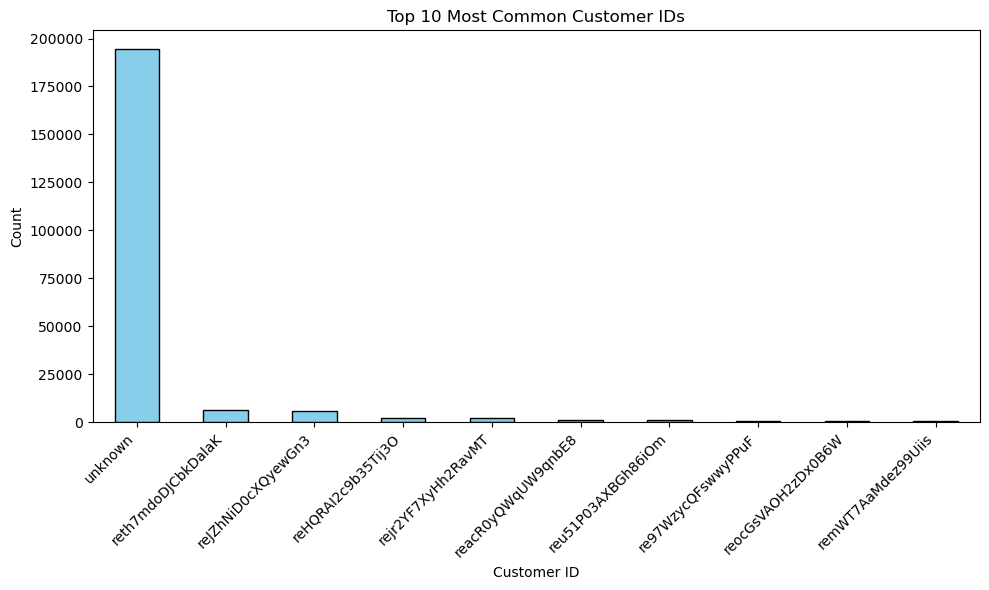

In [126]:
# Plot the top 10 most common customer_id values
customer_id_counts = df_retailer['customer_id'].value_counts()
top_customer_ids = customer_id_counts.head(10)

plt.figure(figsize=(10, 6))
top_customer_ids.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Most Common Customer IDs')
plt.xlabel('Customer ID')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [127]:
# Filter out rows where 'customer_id' is 'unknown'
filtered_customers = df_retailer[df_retailer['customer_id'] != 'unknown']

# Check the remaining customer data
print(f"Number of valid customers: {filtered_customers['customer_id'].nunique()}")
print(f"Total rows after filtering: {len(filtered_customers)}")

Number of valid customers: 1354583
Total rows after filtering: 9671519


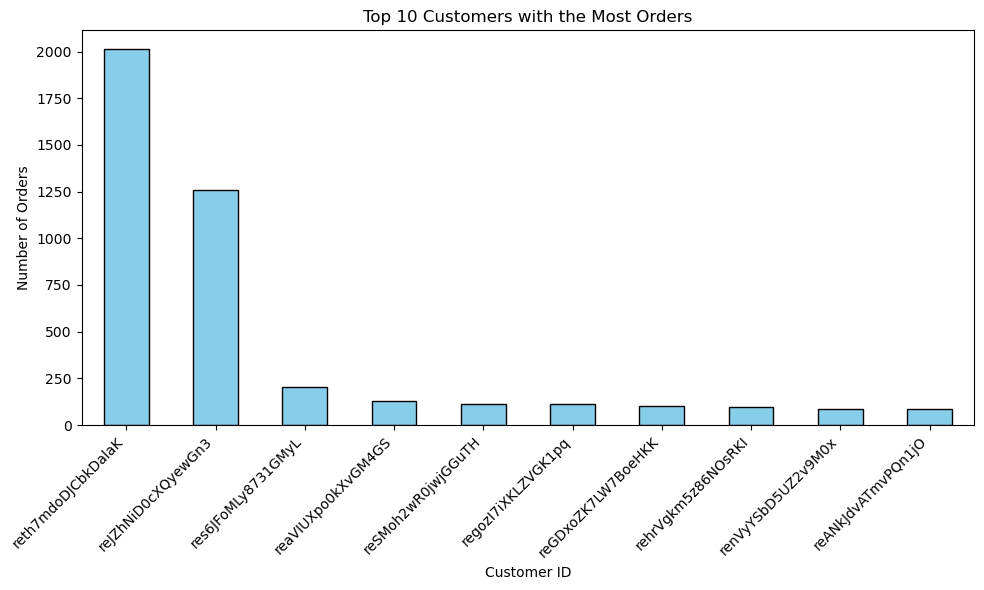

In [128]:
# Filter rows where 'event_name' is 'Order'
orders_data = df_retailer[df_retailer['event_name'] == 'Order']

# Count the number of 'Order' events per customer_id
order_counts = orders_data['customer_id'].value_counts()

# Exclude 'unknown' customer_id if necessary
order_counts = order_counts[order_counts.index != 'unknown']

# Get the top 10 customers with the most 'Order' events
top_order_customers = order_counts.head(10)

# Plot the top customers
plt.figure(figsize=(10, 6))
top_order_customers.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Customers with the Most Orders')
plt.xlabel('Customer ID')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Data Types - Category

#### 'brand' and 'product_name' are analyses, to figure out where the missing values are listed

In [129]:
# Count missing values in 'brand' and 'product_name'
missing_counts = df_retailer[['brand', 'product_name']].isnull().sum()

print("Missing values count:")
print(missing_counts)

Missing values count:
brand           277240
product_name    277240
dtype: int64


In [130]:
# Group by 'event_name' and count rows with missing 'brand' or 'product_name'
missing_grouped = df_retailer[df_retailer[['brand', 'product_name']].isnull().any(axis=1)].groupby('event_name').size()

print("\nMissing values grouped by 'event_name':")
print(missing_grouped)


Missing values grouped by 'event_name':
event_name
Add to cart           24352
Order                  8776
Product Page View    244112
dtype: int64


In [131]:
missing_grouped_by_customer = df_retailer[df_retailer[['brand', 'product_name']].isnull().any(axis=1)].groupby('customer_id').size()

print("\nMissing values grouped by 'customer_id':")
print(missing_grouped_by_customer)


Missing values grouped by 'customer_id':
customer_id
re000kbtVVzPwZcEr4       2
re002l1aOJG3OoCTK8       1
re003RmBjIEYJZkc58       1
re004UY9BuNabOW78B       1
re006sVxOFMUtUxpgO       4
                      ... 
rezzoLVD7Bu7sX6pmh       2
rezzrxhtleUD5t4m0Z       2
rezzuRo8G7gBCoTngR       6
rezzxrPFWJvugyHGNt       1
unknown               5213
Length: 134172, dtype: int64


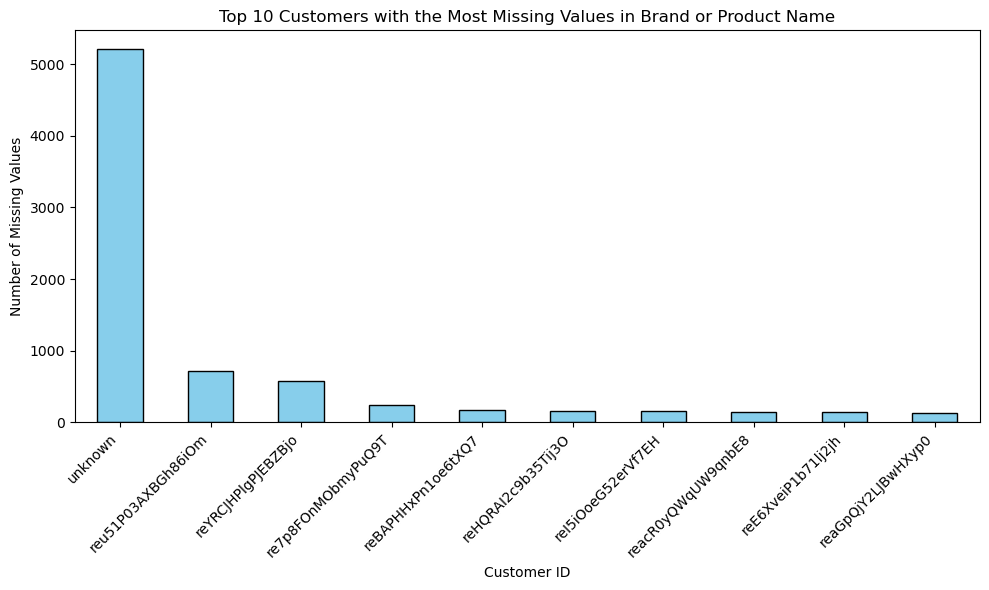

In [132]:
# Sort and select the top 10 customers with the most missing values
top_missing_customers = missing_grouped_by_customer.sort_values(ascending=False).head(10)

# Plot the top 10 customers
plt.figure(figsize=(10, 6))
top_missing_customers.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 10 Customers with the Most Missing Values in Brand or Product Name')
plt.xlabel('Customer ID')
plt.ylabel('Number of Missing Values')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [133]:
# Create a DataFrame showing missingness (True = missing, False = not missing)
missingness_df = df_retailer[['brand', 'product_name', 'customer_id', 'event_name', 'sales', 'quantity']].isnull()

# Correlation of missingness
missing_correlation = missingness_df.corr()

print("\nCorrelation of missingness between columns:")
print(missing_correlation)


Correlation of missingness between columns:
              brand  product_name  customer_id  event_name  sales  quantity
brand           1.0           1.0          NaN         NaN    NaN       NaN
product_name    1.0           1.0          NaN         NaN    NaN       NaN
customer_id     NaN           NaN          NaN         NaN    NaN       NaN
event_name      NaN           NaN          NaN         NaN    NaN       NaN
sales           NaN           NaN          NaN         NaN    NaN       NaN
quantity        NaN           NaN          NaN         NaN    NaN       NaN


#### Decision: Drop Missing values of 'brand' and 'product_name'

In [134]:
# Drop rows where 'brand' or 'product_name' is missing
df_retailer_cleaned = df_retailer.dropna(subset=['brand', 'product_name'])

# Print the shape of the original and cleaned DataFrame to compare
print(f"Original DataFrame shape: {df_retailer.shape}")
print(f"Cleaned DataFrame shape: {df_retailer_cleaned.shape}")

Original DataFrame shape: (9866049, 7)
Cleaned DataFrame shape: (9588809, 7)


### Data Type - Datetime

In [140]:
# Convert 'timestamp_utc' to datetime
df_retailer_cleaned['timestamp_utc'] = pd.to_datetime(df_retailer_cleaned['timestamp_utc'])

# Verify the new data type
print(df_retailer_cleaned['timestamp_utc'].dtypes)

datetime64[ns]


C:\Users\lenna\AppData\Local\Temp\ipykernel_45756\3991831525.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retailer_cleaned['timestamp_utc'] = pd.to_datetime(df_retailer_cleaned['timestamp_utc'])


In [141]:
df_retailer_cleaned['year'] = df_retailer_cleaned['timestamp_utc'].dt.year
df_retailer_cleaned['month'] = df_retailer_cleaned['timestamp_utc'].dt.month
df_retailer_cleaned['day'] = df_retailer_cleaned['timestamp_utc'].dt.day
df_retailer_cleaned['day_of_week'] = df_retailer_cleaned['timestamp_utc'].dt.dayofweek
df_retailer_cleaned['quarter'] = df_retailer_cleaned['timestamp_utc'].dt.quarter

C:\Users\lenna\AppData\Local\Temp\ipykernel_45756\55043726.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retailer_cleaned['year'] = df_retailer_cleaned['timestamp_utc'].dt.year
C:\Users\lenna\AppData\Local\Temp\ipykernel_45756\55043726.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retailer_cleaned['month'] = df_retailer_cleaned['timestamp_utc'].dt.month
C:\Users\lenna\AppData\Local\Temp\ipykernel_45756\55043726.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [143]:
# Group by day and count unique device_ids
timestamp_counts = df_retailer_cleaned.groupby(df_retailer_cleaned['timestamp_utc'].dt.date)['customer_id'].count()

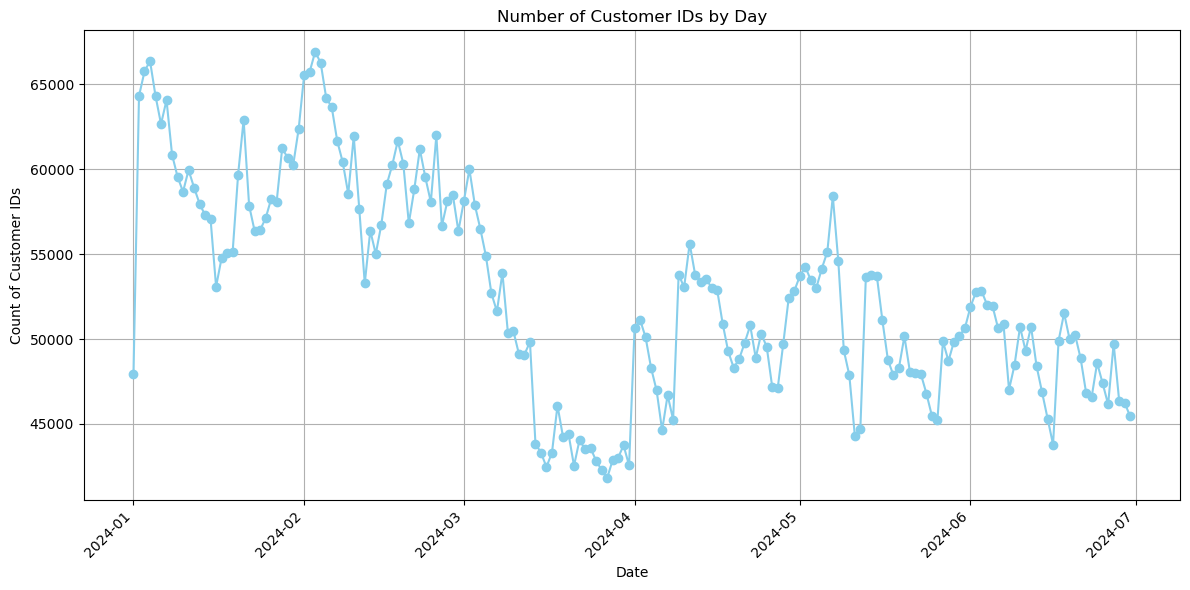

In [144]:
# Plot customer counts by day
plt.figure(figsize=(12, 6))
timestamp_counts.plot(kind='line', marker='o', color='skyblue')
plt.title('Number of Customer IDs by Day')
plt.xlabel('Date')
plt.ylabel('Count of Customer IDs')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.tight_layout()
plt.show()

In [142]:
display(df_retailer_cleaned.head(10))

,customer_id,timestamp_utc,event_name,brand,product_name,sales,quantity,year,month,day,day_of_week,quarter
1,reFs5GI87lXJkJSi9r,2024-06-12 16:16:54,Product Page View,Science Diet,SD Fel A7+ SavCknEnt 24x5.5oz cs,0.00,0.0,2024,6,12,2,2
3,reTjziox2cSrxVq70Y,2024-02-28 04:30:42,Product Page View,Science Diet,SD Fel Adt HBC OFEnt 24x5.5oz cs,0.00,0.0,2024,2,28,2,1
5,reOrpt9vhSwhbPVtni,2024-06-01 22:36:26,Product Page View,Science Diet,SD Ca Adt Lt Ckn 30lb bg,0.00,0.0,2024,6,1,5,2
6,reOrpt9vhSwhbPVtni,2024-06-01 22:43:07,Product Page View,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,0.00,0.0,2024,6,1,5,2
7,reOrpt9vhSwhbPVtni,2024-06-20 14:02:48,Product Page View,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,0.00,0.0,2024,6,20,3,2
8,reOrpt9vhSwhbPVtni,2024-06-06 10:38:51,Order,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,19.99,1.0,2024,6,6,3,2
9,reOrpt9vhSwhbPVtni,2024-06-01 22:47:09,Add to cart,Science Diet,SD Ca Adt Lt SB Ckn 5lb bg,0.00,0.0,2024,6,1,5,2
10,reOrpt9vhSwhbPVtni,2024-05-18 14:22:29,Product Page View,Science Diet,SD Ca Adt SmPws 12x3.5oz VarPk,0.00,0.0,2024,5,18,5,2
11,reOrpt9vhSwhbPVtni,2024-05-18 16:47:38,Product Page View,Science Diet,SD Ca Adt SmPws 12x3.5oz VarPk,0.00,0.0,2024,5,18,5,2
12,reOrpt9vhSwhbPVtni,2024-05-18 16:28:05,Product Page View,Science Diet,SD Ca Adt SmPws 12x3.5oz VarPk,0.00,0.0,2024,5,18,5,2


In [136]:
df_retailer_cleaned.shape

(9588809, 7)